In [1]:
# Instala librerías necesarias
!pip install torch

In [2]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

### A - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1]

### I - Grilla de 5 x 5:

Época 0, Pérdida total: 0.7217346429824829
Época 1000, Pérdida total: 0.0020023551769554615
Época 2000, Pérdida total: 0.0008377552730962634
Época 3000, Pérdida total: 0.0006091966642998159
Época 4000, Pérdida total: 0.0005851970054209232
Época 5000, Pérdida total: 0.0005757506587542593
Época 6000, Pérdida total: 0.0005724532529711723
Época 7000, Pérdida total: 0.0005713672144338489
Época 8000, Pérdida total: 0.0005685737705789506
Época 9000, Pérdida total: 0.0005673002451658249


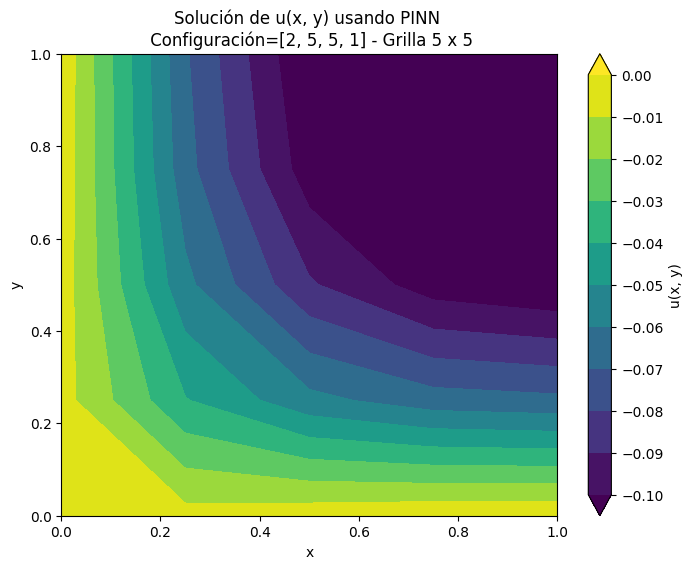

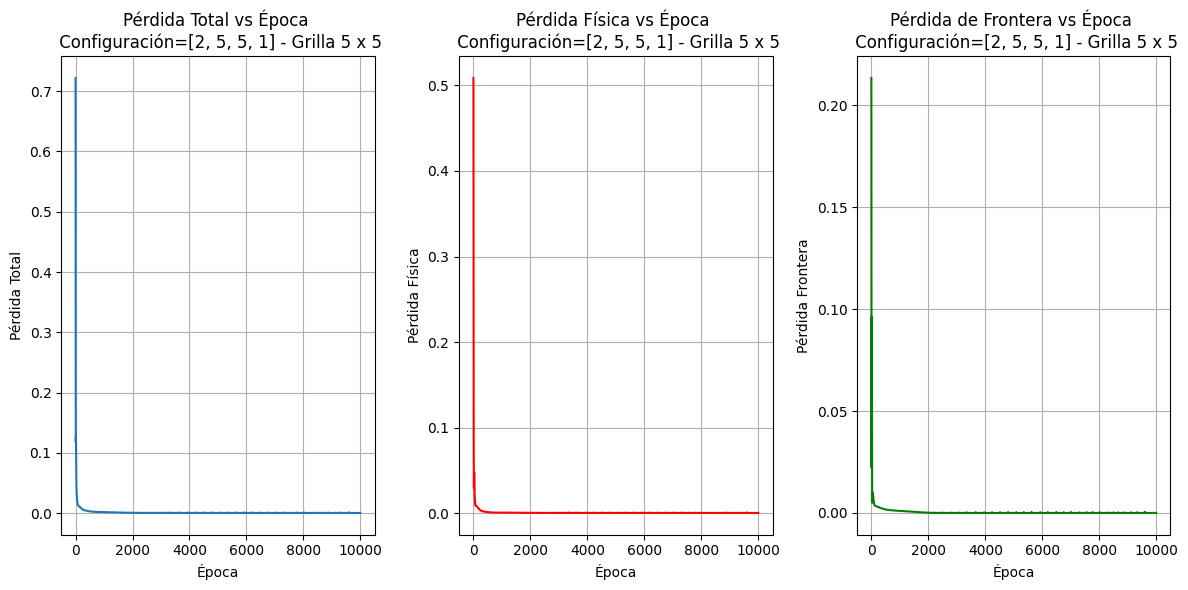

In [3]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento
x_vals = np.linspace(0, 1, 5)
y_vals = np.linspace(0, 1, 5)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf
def plot_solution_contourf(u_pred):
    Z = u_pred.reshape((5, 5))  # Reshape para formar la grilla 5x5

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 5), np.linspace(0, 1, 5), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

### II - Grilla de 10 x 10:

Época 0, Pérdida total: 0.25923460721969604
Época 1000, Pérdida total: 0.0007829813985154033
Época 2000, Pérdida total: 0.00047992687905207276
Época 3000, Pérdida total: 0.0008875130442902446
Época 4000, Pérdida total: 0.0004552682803478092
Época 5000, Pérdida total: 0.00045401178067550063
Época 6000, Pérdida total: 0.0004528460849542171
Época 7000, Pérdida total: 0.0004865600785706192
Época 8000, Pérdida total: 0.0005447897710837424
Época 9000, Pérdida total: 0.00045088009210303426


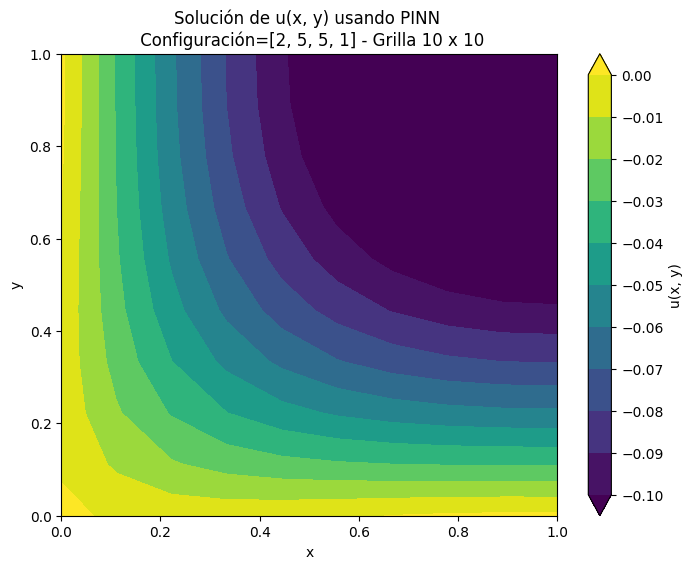

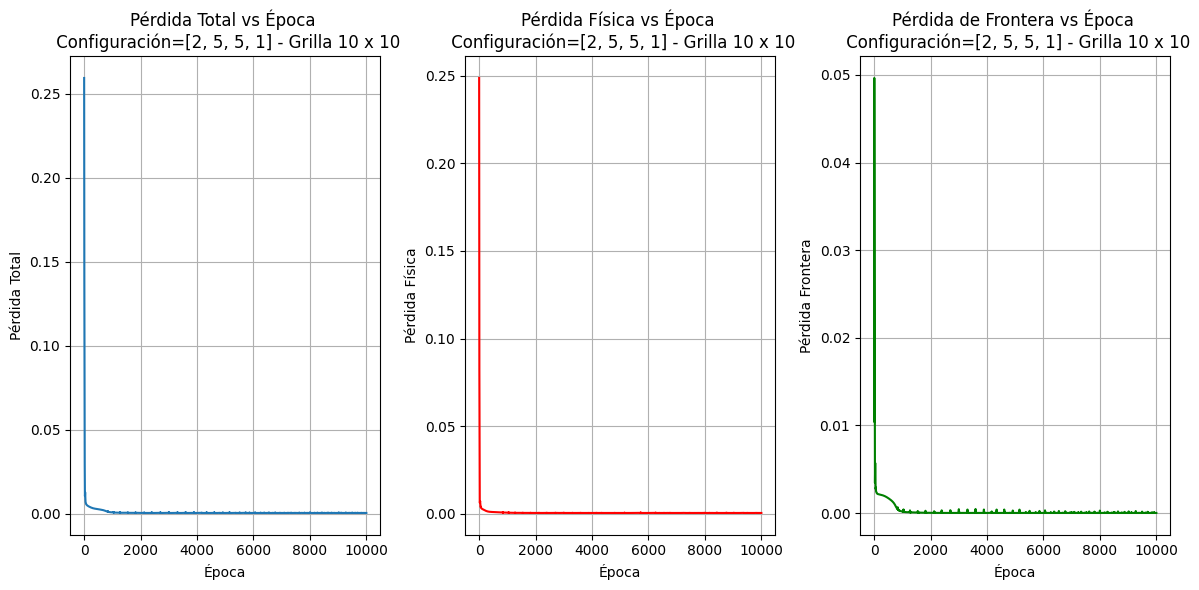

In [4]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento (10x10)
x_vals = np.linspace(0, 1, 10)
y_vals = np.linspace(0, 1, 10)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf
def plot_solution_contourf(u_pred):
    Z = u_pred.reshape((10, 10))  # Reshape para formar la grilla 10x10

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 10), np.linspace(0, 1, 10), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

### III - Grilla de 20 x 20:

Época 0, Pérdida total: 0.22913841903209686
Época 1000, Pérdida total: 0.0014624892501160502
Época 2000, Pérdida total: 0.0008193397079594433
Época 3000, Pérdida total: 0.0005976463435217738
Época 4000, Pérdida total: 0.0004287800402380526
Época 5000, Pérdida total: 0.00041578561649657786
Época 6000, Pérdida total: 0.0004123916442040354
Época 7000, Pérdida total: 0.0004098454082850367
Época 8000, Pérdida total: 0.0004101622907910496
Época 9000, Pérdida total: 0.0004061268991790712


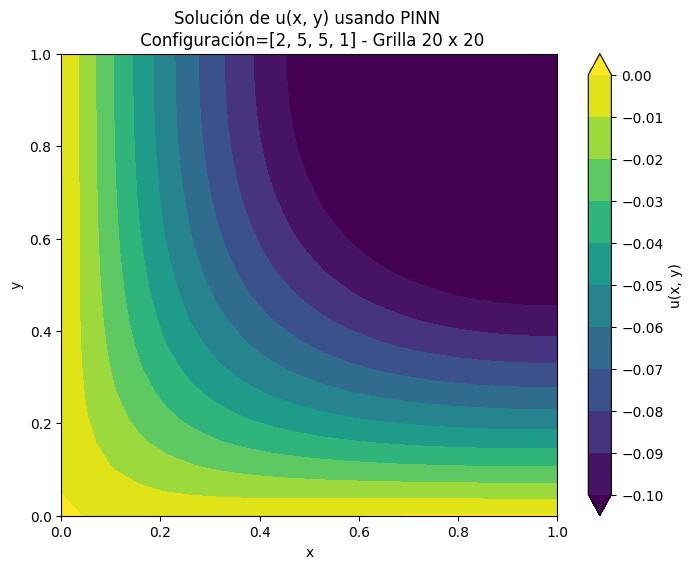

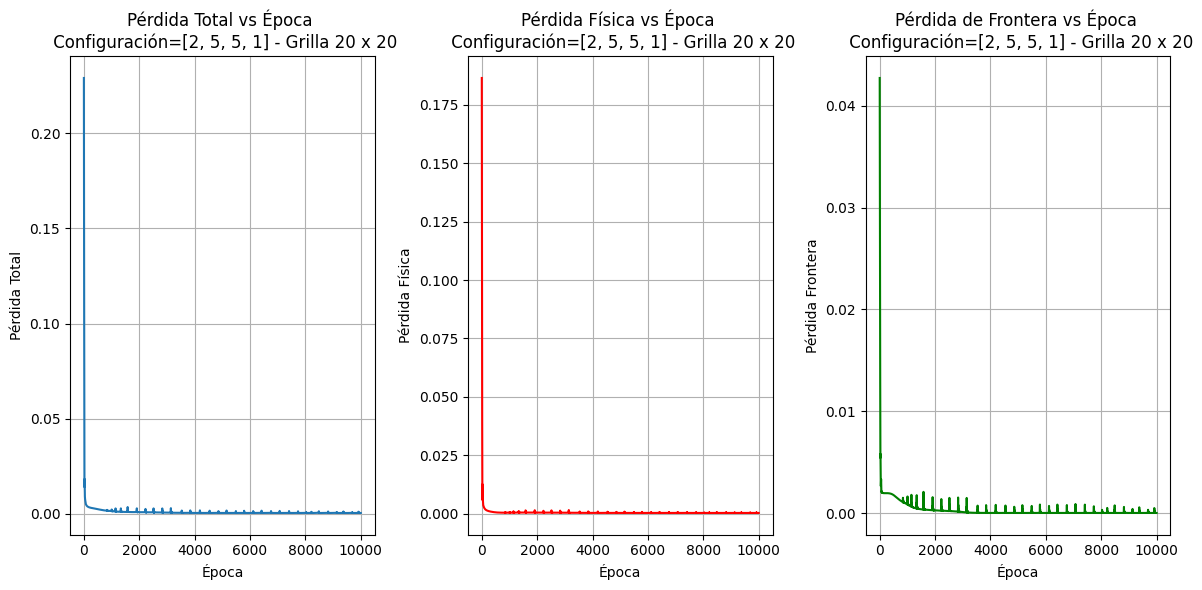

In [5]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear la grilla de puntos de entrenamiento (20x20)
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)
x, y = np.meshgrid(x_vals, y_vals)
xy_interior = torch.tensor(np.c_[x.ravel(), y.ravel()], dtype=torch.float32, requires_grad=True)

# Crear puntos de la frontera
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf
def plot_solution_contourf(u_pred):
    Z = u_pred.reshape((20, 20))  # Reshape para formar la grilla 20x20

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 20), np.linspace(0, 1, 20), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos de la cuadrícula interior
with torch.no_grad():
    u_pred = model(xy_interior).numpy()

# Graficar la solución con contourf
plot_solution_contourf(u_pred)

# Graficar las pérdidas
plot_losses()

## B - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1] utilizando muestreos aleatorios de los puntos de colocación.

### I - Cantidad de puntos de colocación aleatorios y uniformes equivalente a grilla de 5x5.

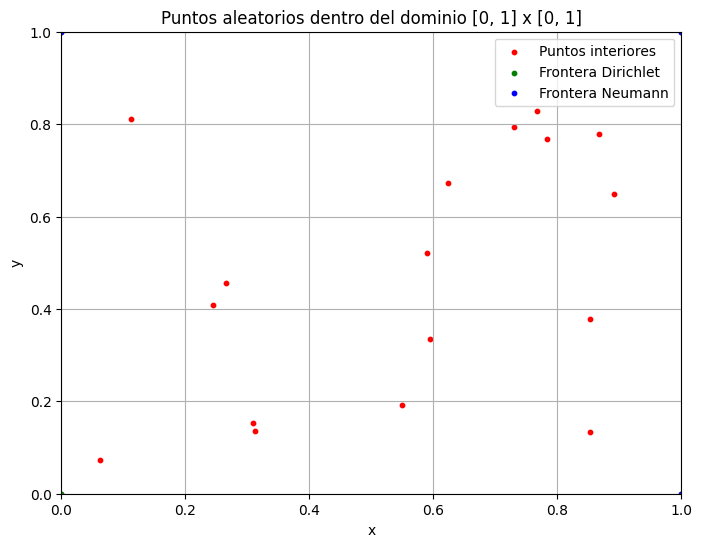

Época 0, Pérdida total: 0.4065835177898407
Época 1000, Pérdida total: 0.0010464740917086601
Época 2000, Pérdida total: 0.0008796906331554055
Época 3000, Pérdida total: 0.0006647607660852373
Época 4000, Pérdida total: 0.0006761623080819845
Época 5000, Pérdida total: 0.0006216460024006665
Época 6000, Pérdida total: 0.0006262878305278718
Época 7000, Pérdida total: 0.0006715271156281233
Época 8000, Pérdida total: 0.00062264793086797
Época 9000, Pérdida total: 0.0006241629598662257


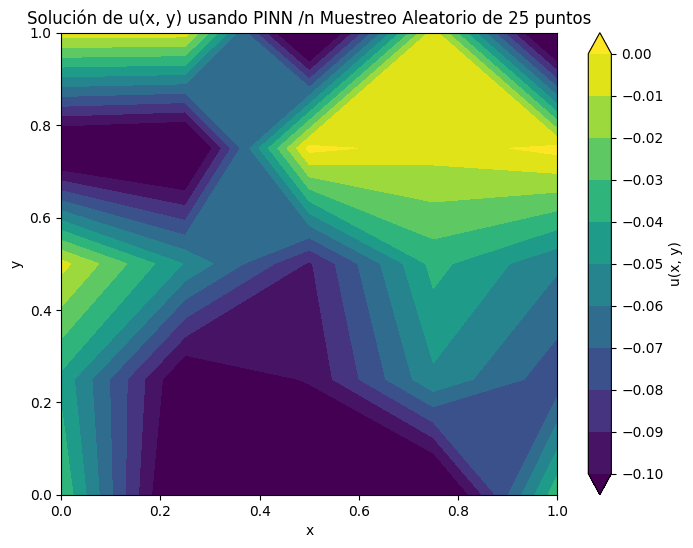

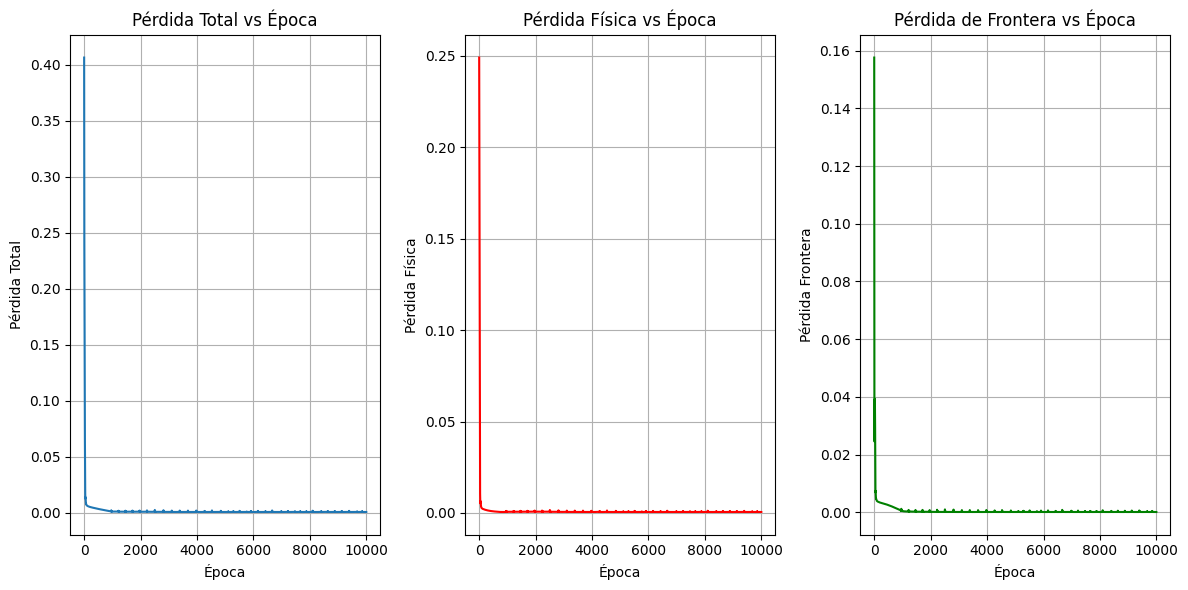

In [19]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear un muestreo aleatorio de puntos dentro del dominio [0, 1] x [0, 1]
num_samples = 25  # Total de 25 puntos
num_boundary_samples = int(0.32 * num_samples)  # El 32% de puntos para la frontera
num_interior_samples = num_samples - num_boundary_samples  # El 68% para el interior

# Crear puntos aleatorios para el interior (68% de los puntos)
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras (20% de los puntos)
x_vals = np.linspace(0, 1, 2)
y_vals = np.linspace(0, 1, 2)

# Puntos en las fronteras
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Concatenar todos los puntos (interior y fronteras)
xy_total = torch.cat((xy_interior_random, xy_b0, xy_b1, xy_nx, xy_ny), 0)

# Graficar los puntos aleatorios de colocación con colores diferenciados
def plot_random_points():
    plt.figure(figsize=(8, 6))

    # Puntos interiores (en rojo)
    plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos interiores', s=10)

    # Puntos de la frontera Dirichlet (en verde)
    plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Frontera Dirichlet', s=10)
    plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green', s=10)

    # Puntos de la frontera Neumann (en azul)
    plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='blue', label='Frontera Neumann', s=10)
    plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='blue', s=10)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Puntos aleatorios dentro del dominio [0, 1] x [0, 1]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar los puntos
plot_random_points()

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior_random)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf (usando todos los puntos)
def plot_solution_contourf(u_pred):
    # Reshape para formar la grilla 10x10
    Z = u_pred.reshape((5, 5))
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 5), np.linspace(0, 1, 5), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 25 puntos")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos del dominio (interior y frontera)
with torch.no_grad():
    u_pred_total = model(xy_total).detach().numpy()

# Graficar la solución y las pérdidas
plot_solution_contourf(u_pred_total)
plot_losses()

### II - Cantidad de puntos de colocación aleatorios y uniformes equivalente a grilla de 10x10.

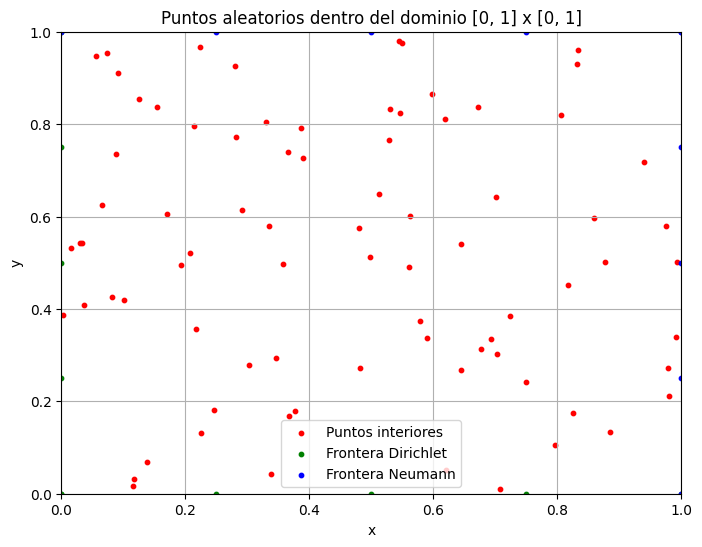

Época 0, Pérdida total: 0.4682226777076721
Época 1000, Pérdida total: 0.0017744529759511352
Época 2000, Pérdida total: 0.0012783745769411325
Época 3000, Pérdida total: 0.0011262698099017143
Época 4000, Pérdida total: 0.0010426533408463001
Época 5000, Pérdida total: 0.0008189690997824073
Época 6000, Pérdida total: 0.0008233524858951569
Época 7000, Pérdida total: 0.0007856531301513314
Época 8000, Pérdida total: 0.0007901070057414472
Época 9000, Pérdida total: 0.0007929684361442924


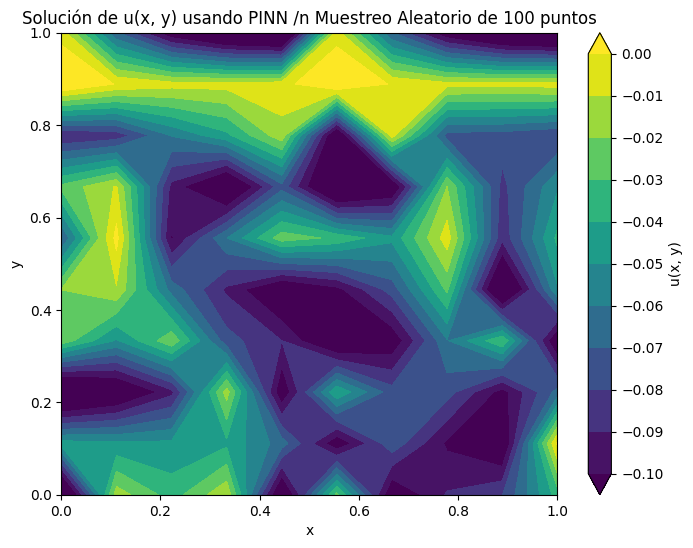

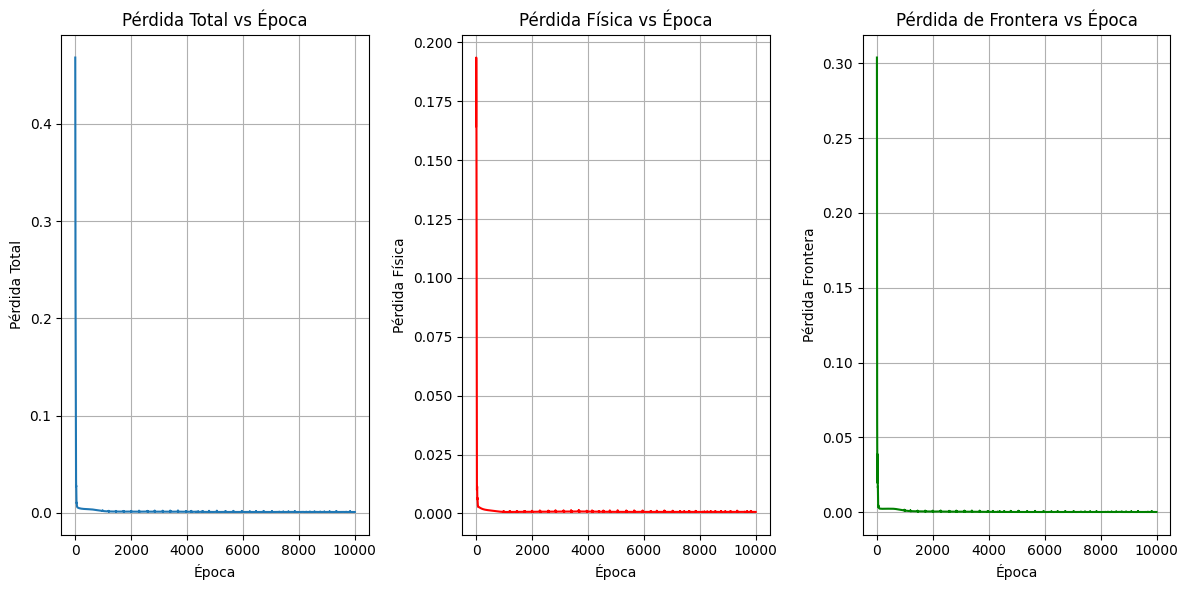

In [20]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear un muestreo aleatorio de puntos dentro del dominio [0, 1] x [0, 1]
num_samples = 100  # Total de 100 puntos
num_boundary_samples = int(0.2 * num_samples)  # El 20% de puntos para la frontera
num_interior_samples = num_samples - num_boundary_samples  # El 80% para el interior

# Crear puntos aleatorios para el interior (80% de los puntos)
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras (20% de los puntos)
x_vals = np.linspace(0, 1, 5)
y_vals = np.linspace(0, 1, 5)

# Puntos en las fronteras
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Concatenar todos los puntos (interior y fronteras)
xy_total = torch.cat((xy_interior_random, xy_b0, xy_b1, xy_nx, xy_ny), 0)

# Graficar los puntos aleatorios de colocación con colores diferenciados
def plot_random_points():
    plt.figure(figsize=(8, 6))

    # Puntos interiores (en rojo)
    plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos interiores', s=10)

    # Puntos de la frontera Dirichlet (en verde)
    plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Frontera Dirichlet', s=10)
    plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green', s=10)

    # Puntos de la frontera Neumann (en azul)
    plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='blue', label='Frontera Neumann', s=10)
    plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='blue', s=10)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Puntos aleatorios dentro del dominio [0, 1] x [0, 1]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar los puntos
plot_random_points()

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior_random)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf (usando todos los puntos)
def plot_solution_contourf(u_pred):
    # Reshape para formar la grilla 10x10
    Z = u_pred.reshape((10, 10))
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 10), np.linspace(0, 1, 10), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 100 puntos")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos del dominio (interior y frontera)
with torch.no_grad():
    u_pred_total = model(xy_total).detach().numpy()

# Graficar la solución y las pérdidas
plot_solution_contourf(u_pred_total)
plot_losses()

### III - Cantidad de puntos de colocación aleatorios y uniformes equivalente a grilla de 20x20.

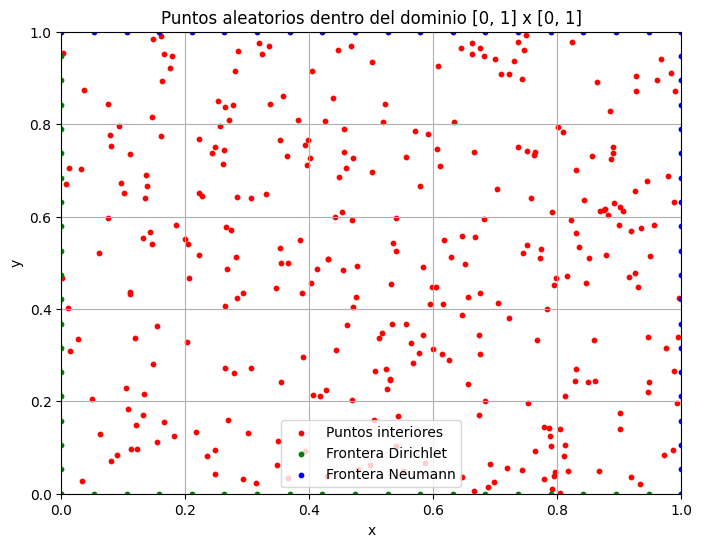

Época 0, Pérdida total: 0.7581501007080078
Época 1000, Pérdida total: 0.002751345746219158
Época 2000, Pérdida total: 0.0011801427463069558
Época 3000, Pérdida total: 0.0011152082588523626
Época 4000, Pérdida total: 0.0010922905057668686
Época 5000, Pérdida total: 0.001070824800990522
Época 6000, Pérdida total: 0.0010603959672152996
Época 7000, Pérdida total: 0.0010588980512693524
Época 8000, Pérdida total: 0.0010573741747066379
Época 9000, Pérdida total: 0.0010580080561339855


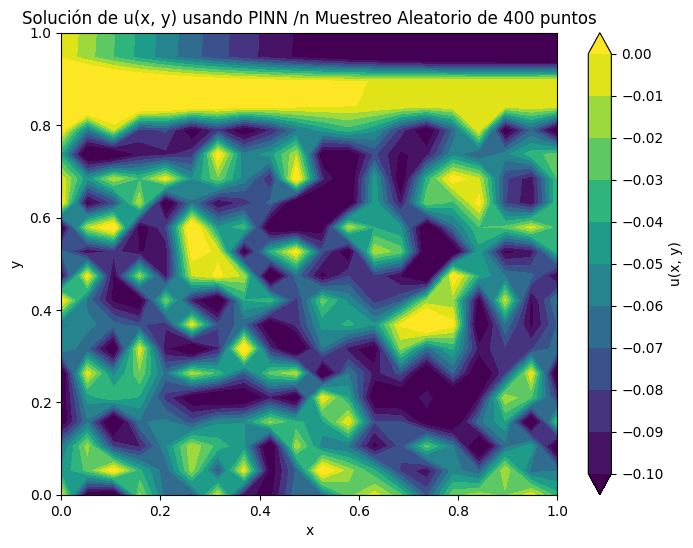

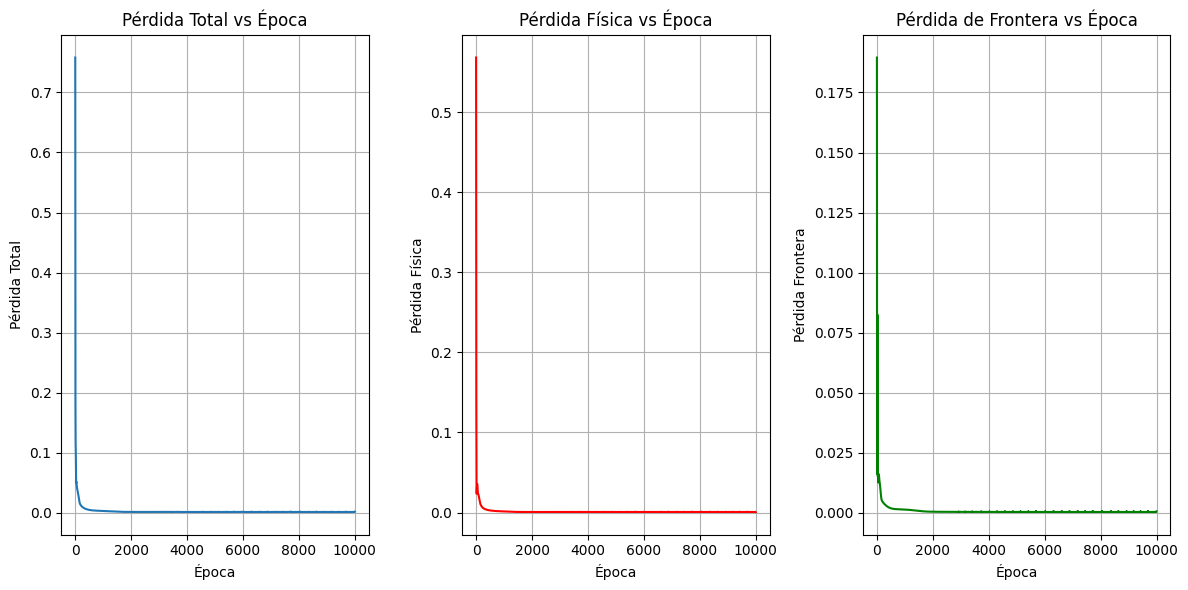

In [21]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear un muestreo aleatorio de puntos dentro del dominio [0, 1] x [0, 1]
num_samples = 400  # Total de 400 puntos
num_boundary_samples = int(0.2 * num_samples)  # El 20% de puntos para la frontera
num_interior_samples = num_samples - num_boundary_samples  # El 80% para el interior

# Crear puntos aleatorios para el interior (80% de los puntos)
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras (20% de los puntos)
x_vals = np.linspace(0, 1, 20)
y_vals = np.linspace(0, 1, 20)

# Puntos en las fronteras
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Concatenar todos los puntos (interior y fronteras)
xy_total = torch.cat((xy_interior_random, xy_b0, xy_b1, xy_nx, xy_ny), 0)

# Graficar los puntos aleatorios de colocación con colores diferenciados
def plot_random_points():
    plt.figure(figsize=(8, 6))

    # Puntos interiores (en rojo)
    plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos interiores', s=10)

    # Puntos de la frontera Dirichlet (en verde)
    plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Frontera Dirichlet', s=10)
    plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green', s=10)

    # Puntos de la frontera Neumann (en azul)
    plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='blue', label='Frontera Neumann', s=10)
    plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='blue', s=10)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Puntos aleatorios dentro del dominio [0, 1] x [0, 1]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar los puntos
plot_random_points()

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior_random)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf (usando todos los puntos)
def plot_solution_contourf(u_pred):
    # Reshape para formar la grilla 20x20
    Z = u_pred.reshape((20, 20))
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 20), np.linspace(0, 1, 20), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 400 puntos")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos del dominio (interior y frontera)
with torch.no_grad():
    u_pred_total = model(xy_total).detach().numpy()

# Graficar la solución y las pérdidas
plot_solution_contourf(u_pred_total)
plot_losses()

### IV - Cantidad de puntos de colocación aleatorios y uniformes equivalente a grilla de 100x100

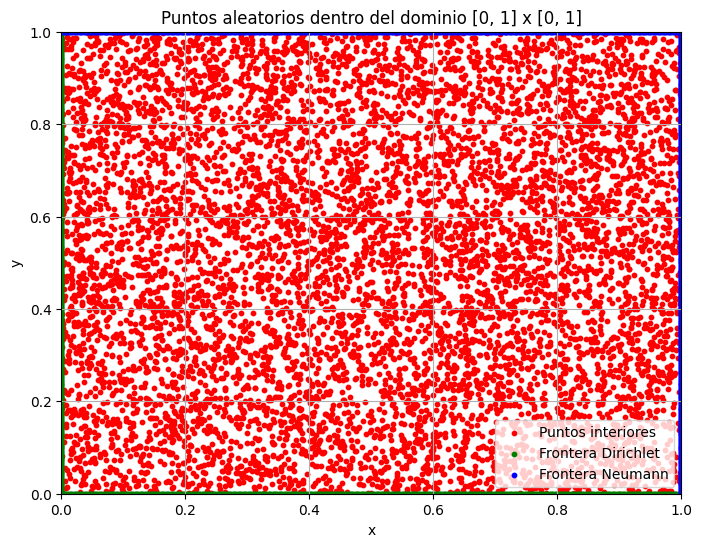

Época 0, Pérdida total: 1.3869961500167847
Época 1000, Pérdida total: 0.0017230808734893799
Época 2000, Pérdida total: 0.001417129416950047
Época 3000, Pérdida total: 0.0012791522312909365
Época 4000, Pérdida total: 0.0012179601471871138
Época 5000, Pérdida total: 0.0011740564368665218
Época 6000, Pérdida total: 0.0012045304756611586
Época 7000, Pérdida total: 0.0011741685448214412
Época 8000, Pérdida total: 0.0011647660285234451
Época 9000, Pérdida total: 0.0011557438410818577


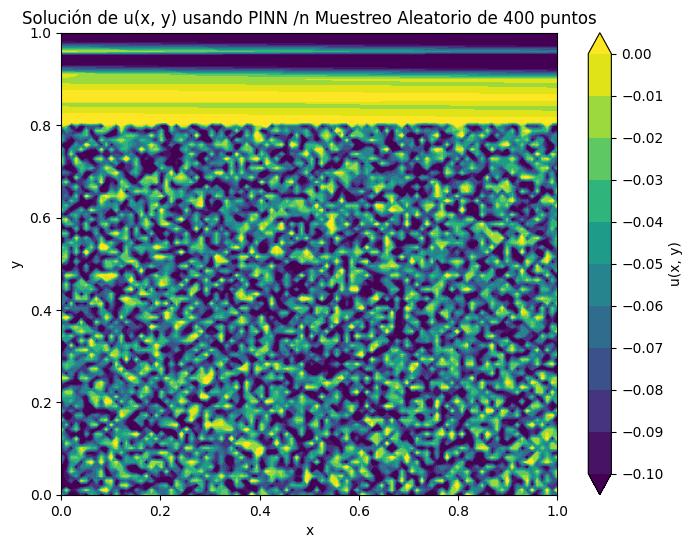

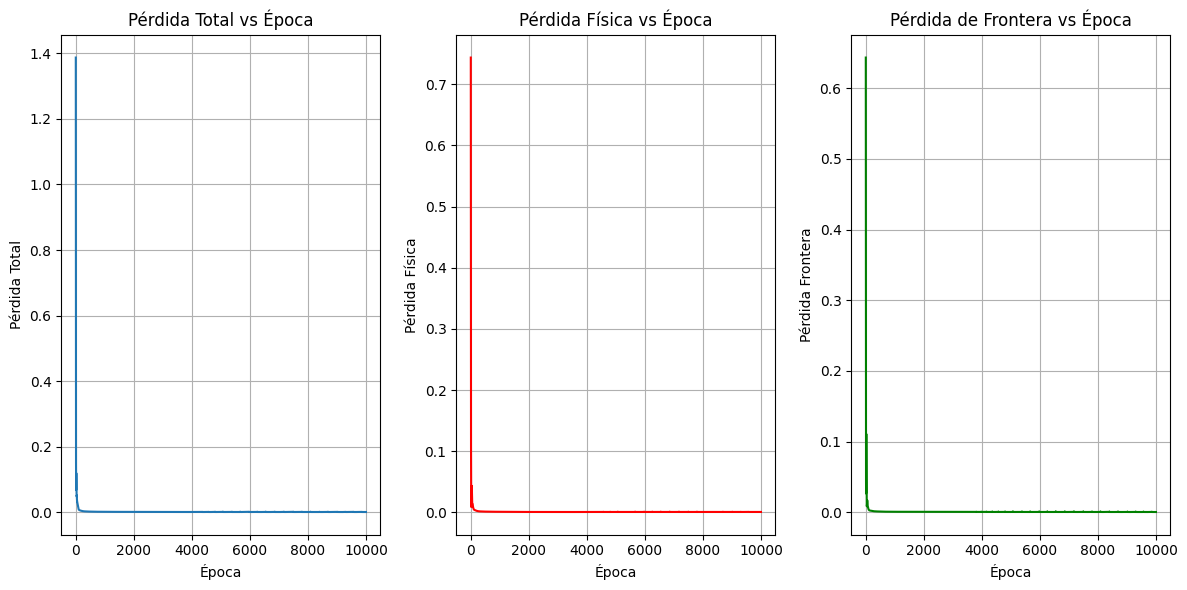

In [3]:
# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Tanh(),
            nn.Linear(5, 5),
            nn.Tanh(),
            nn.Linear(5, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Definir el modelo, el optimizador y el criterio
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

# Función de pérdida
def loss_fn(xy):
    xy.requires_grad = True
    u = model(xy)
    grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], xy, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], xy, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    laplace_u = u_xx + u_yy
    source_term = 0.5 * torch.exp(u)
    interior_loss = torch.mean((laplace_u - source_term) ** 2)
    return interior_loss

# Condiciones de frontera
def boundary_loss(xy, boundary_type):
    xy.requires_grad = True
    u = model(xy)
    if boundary_type == "Dirichlet":
        return torch.mean((u - 0) ** 2)
    elif boundary_type == "Neumann_x":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 0]) ** 2)
    elif boundary_type == "Neumann_y":
        grads = torch.autograd.grad(u, xy, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return torch.mean((grads[:, 1]) ** 2)

# Crear un muestreo aleatorio de puntos dentro del dominio [0, 1] x [0, 1]
num_samples = 10000  # Total de 10000 puntos
num_boundary_samples = int(0.2 * num_samples)  # El 20% de puntos para la frontera
num_interior_samples = num_samples - num_boundary_samples  # El 80% para el interior

# Crear puntos aleatorios para el interior (80% de los puntos)
xy_interior_random = torch.rand(num_interior_samples, 2, dtype=torch.float32, requires_grad=True)

# Crear puntos para las fronteras (20% de los puntos)
x_vals = np.linspace(0, 1, 500)
y_vals = np.linspace(0, 1, 500)

# Puntos en las fronteras
xy_b0 = torch.tensor(np.c_[x_vals, np.zeros_like(x_vals)], dtype=torch.float32, requires_grad=True)  # Frontera u(0, y) = 0
xy_b1 = torch.tensor(np.c_[np.zeros_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)  # Frontera u(x, 0) = 0
xy_nx = torch.tensor(np.c_[np.ones_like(y_vals), y_vals], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en x=1
xy_ny = torch.tensor(np.c_[x_vals, np.ones_like(x_vals)], dtype=torch.float32, requires_grad=True)   # Frontera Neumann en y=1

# Concatenar todos los puntos (interior y fronteras)
xy_total = torch.cat((xy_interior_random, xy_b0, xy_b1, xy_nx, xy_ny), 0)

# Graficar los puntos aleatorios de colocación con colores diferenciados
def plot_random_points():
    plt.figure(figsize=(8, 6))

    # Puntos interiores (en rojo)
    plt.scatter(xy_interior_random[:, 0].detach().numpy(), xy_interior_random[:, 1].detach().numpy(), color='red', label='Puntos interiores', s=10)

    # Puntos de la frontera Dirichlet (en verde)
    plt.scatter(xy_b0[:, 0].detach().numpy(), xy_b0[:, 1].detach().numpy(), color='green', label='Frontera Dirichlet', s=10)
    plt.scatter(xy_b1[:, 0].detach().numpy(), xy_b1[:, 1].detach().numpy(), color='green', s=10)

    # Puntos de la frontera Neumann (en azul)
    plt.scatter(xy_nx[:, 0].detach().numpy(), xy_nx[:, 1].detach().numpy(), color='blue', label='Frontera Neumann', s=10)
    plt.scatter(xy_ny[:, 0].detach().numpy(), xy_ny[:, 1].detach().numpy(), color='blue', s=10)

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Puntos aleatorios dentro del dominio [0, 1] x [0, 1]")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar los puntos
plot_random_points()

# Listas para almacenar las pérdidas durante el entrenamiento
losses_total = []
losses_interior = []
losses_boundary = []

# Entrenamiento
epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()

    # Pérdidas por cada término
    loss_interior = loss_fn(xy_interior_random)
    loss_boundary_0 = boundary_loss(xy_b0, "Dirichlet")
    loss_boundary_1 = boundary_loss(xy_b1, "Dirichlet")
    loss_neumann_x = boundary_loss(xy_nx, "Neumann_x")
    loss_neumann_y = boundary_loss(xy_ny, "Neumann_y")

    # Pérdida total
    loss = loss_interior + loss_boundary_0 + loss_boundary_1 + loss_neumann_x + loss_neumann_y
    loss.backward()
    optimizer.step()

    # Guardar las pérdidas para graficarlas
    losses_total.append(loss.item())
    losses_interior.append(loss_interior.item())
    losses_boundary.append(loss_boundary_0.item() + loss_boundary_1.item() + loss_neumann_x.item() + loss_neumann_y.item())

    if epoch % 1000 == 0:
        print(f"Época {epoch}, Pérdida total: {loss.item()}")

# Graficar la solución con contourf (usando todos los puntos)
def plot_solution_contourf(u_pred):
    # Reshape para formar la grilla 100x100
    Z = u_pred.reshape((100, 100))
    plt.figure(figsize=(8, 6))
    cp = plt.contourf(np.linspace(0, 1, 100), np.linspace(0, 1, 100), Z, cmap='viridis', levels=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.10, vmax=0.00, extend='both')
    plt.colorbar(cp, label="u(x, y)", extend='both', ticks=[-0.10, -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Solución de u(x, y) usando PINN /n Muestreo Aleatorio de 10000 puntos")
    plt.show()

# Graficar las pérdidas
def plot_losses():
    plt.figure(figsize=(12, 6))

    # Subgráficas para las pérdidas
    plt.subplot(1, 3, 1)
    plt.plot(losses_total, label='Pérdida total')
    plt.title('Pérdida Total vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Total')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(losses_interior, label='Pérdida interior', color='red')
    plt.title('Pérdida Física vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Física')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(losses_boundary, label='Pérdida de la frontera', color='green')
    plt.title('Pérdida de Frontera vs Época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida Frontera')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Evaluar la red en los puntos del dominio (interior y frontera)
with torch.no_grad():
    u_pred_total = model(xy_total).detach().numpy()

# Graficar la solución y las pérdidas
plot_solution_contourf(u_pred_total)
plot_losses()